In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# !rm -rf /content

In [5]:
!git clone https://github.com/interactivetech/centernet-tutorial/

fatal: destination path 'centernet-tutorial' already exists and is not an empty directory.


In [6]:
import torch
import sys
sys.path.insert(0,'/content/centernet-tutorial/')
from data_gen import ShapeDataset
import matplotlib.pyplot as plt
from PIL import Image
from data import COCODetectionDataset, coco_detection_collate_fn, train_transform_norm, validation_transform_norm
from tqdm import tqdm
import numpy as np
from model import centernet
from loss import centerloss4
from train import train
from utils import pred2box_multiclass, filter_and_nms
import cv2

<h3> Table of Contents </h3>
<ul>
<li><a href="#Prelims">Prelims</a></li>
<li><a href="#Background">Background</a><ul>
<li><a href="#single-vs-two-stage">Single Stage vs Two Stage</a></li>
<li><a href="#Centernet">Centernet</a></li>
</ul>
<li><a href="#Preprocessing">Preprocessing</a></li>
<ul>
<li><a href="#Encode-Location-as-Gaussian-Keypoints">Encode Location as Gaussian Keypoints</a></li>
<li><a href="#Encode-Width-and-Height">Encode Width and Height</a></li>
</ul>
<li><a href="#Model Architecture">Model Architecture</a></li>
<ul>
<li><a href="#Backbone">Backbone</a></li>
<li><a href="#Class Head">Class Head</a></li>
<li><a href="#Regression Head">Regression Head</a></li>
<li><a href="#Initalization for Focal Loss">Initalization for Focal Loss</a></li>
</ul>
<li><a href="#Loss Function">Loss Function</a></li>
<ul>
<li><a href="#Focal Loss">Focal Loss</a></li>
<li><a href="#Regression Loss">Regression Loss</a></li>
</ul>
<li><a href="#Prepare-Training-Model">Prepare Training Model</a></li>
<li><a href="#Train-Model">Train Model</a></li>
<li><a href="#Evaluate-Loss-Curves">Evaluate Loss Curves</a></li>
<li><a href="#Evaluate-Model-Predictions">Evaluate Model Predictions</a></li>

</ul>


# Prelims

Generate Dataset

In [7]:
s = ShapeDataset(n_images = 8,n_circles=1,n_rectangles=1)
s.gen_dataset()

Num Circle: 1
Num Circle+Rect: 2
Num Anns: 3
[{'segmentation': [], 'area': 3600, 'iscrowd': 0, 'image_id': 1, 'bbox': [375, 316, 60, 60], 'category_id': 0, 'id': 1}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 1, 'bbox': [328, 353, 32, 32], 'category_id': 1, 'id': 2}]
[{'file_name': 'dummy_1.png', 'height': 512, 'width': 512, 'id': 1}]
Num Circle: 1
Num Circle+Rect: 2
Num Anns: 5
[{'segmentation': [], 'area': 3600, 'iscrowd': 0, 'image_id': 1, 'bbox': [375, 316, 60, 60], 'category_id': 0, 'id': 1}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 1, 'bbox': [328, 353, 32, 32], 'category_id': 1, 'id': 2}, {'segmentation': [], 'area': 3364, 'iscrowd': 0, 'image_id': 2, 'bbox': [47, 117, 58, 58], 'category_id': 0, 'id': 3}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 2, 'bbox': [403, 319, 32, 32], 'category_id': 1, 'id': 4}]
[{'file_name': 'dummy_1.png', 'height': 512, 'width': 512, 'id': 1}, {'file_name': 'dummy_2.png', 'height': 512, 'width'

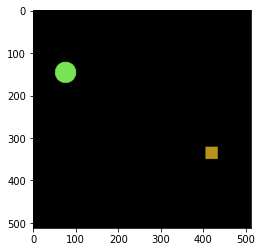

In [8]:
im = Image.open('dummy_2.png')
plt.imshow(im)

In [9]:
ds = COCODetectionDataset(img_dir='/content/',
                ann_json='/content/coco_shapes.json',
                IMG_RESOLUTION=512,
                transform=train_transform_norm)
val_ds = COCODetectionDataset(img_dir='/content/',
                ann_json='/content/coco_shapes.json',
                IMG_RESOLUTION=512,
                transform=validation_transform_norm)
BATCH_SIZE = 8
train_loader = torch.utils.data.DataLoader(ds,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=2,
                                        pin_memory=True,
                                        collate_fn = coco_detection_collate_fn)
val_loader = torch.utils.data.DataLoader(ds,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=0,
                                        pin_memory=True,
                                        collate_fn = coco_detection_collate_fn)


label_map: {0: 0, 1: 1}
label_map: {0: 0, 1: 1}


In [10]:
len(ds)

8

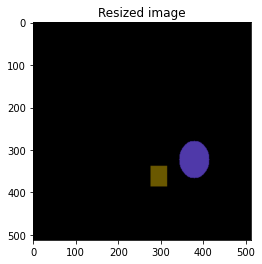

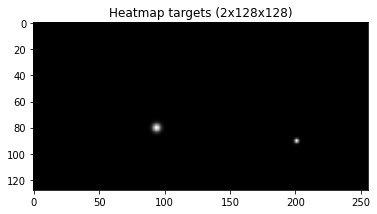

In [11]:
img, hm, reg, wh,reg_mask,inds, in_size, out_size, intermediate_size, scale, boxes_aug, target= ds[0]
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
img_u = img.transpose(1,2,0)*std + mean# unnormalize
# img = img 
plt.imshow(img_u)
plt.title("Resized image")

plt.show()
c,h,w = hm.shape
nrows = 1
ncols = 2
hm_u = hm.reshape(nrows, ncols, h, w).swapaxes(1,2).reshape(h*nrows, w*ncols)
# hm_u = hm.transpose(1,2,0)
plt.imshow(hm_u,cmap='gray')
plt.title("Heatmap targets (2x128x128)")
plt.show()

# Background

## Single Stage vs Two Stage
<a id='single-vs-two-stage'></a>

## Centernet

# Preprocessing

## Encode Class Keypoints

```python
def draw_umich_gaussian(heatmap, center, radius, k=1):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
  return heatmap
```

## Encoding bounding boxes

```python
centers = np.array([bboxes[:,0]+bboxes[:,2]//2,bboxes[:,1]+bboxes[:,3]//2,bboxes[:,2],bboxes[:,3]]).T
for ind,(c,l )in enumerate(zip(centers,classes)):
    h, w = c[3]/MODEL_SCALE, c[2]/MODEL_SCALE
    radius = gaussian_radius((math.ceil(h), math.ceil(w)))
    radius = max(0, int(radius))
    # print("radius:", radius)
    draw_umich_gaussian(hm[l], [int(c[0])//MODEL_SCALE,int(c[1])//MODEL_SCALE], 
                            radius)
    # draw_msra_gaussian(hm[l], [int(c[0])//MODEL_SCALE,int(c[1])//MODEL_SCALE], 
    #                         radius)
    reg_mask[ind] = 1
    wh[ind] = c[2:]/input_size
    draw_dense_reg(reg,hm[l],c[:2]//MODEL_SCALE,wh[ind],radius)
    inds[ind] = (int(c[1])//MODEL_SCALE)*feature_scale + (int(c[0])//MODEL_SCALE)
```

## Encode Width and Height Regression

```python
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)

  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value

  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]

  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]

  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap
```

# Model Architecture


## Backbone

```python
if model_name == 'mv3':
            basemodel = torchvision.models.mobilenet_v3_small(pretrained=True)
            num_ch = 576
elif model_name == 'resnet18':
            basemodel = torchvision.models.resnet18(pretrained=True)
            num_ch = 512
basemodel = nn.Sequential(*list(basemodel.children())[:-2])
# set basemodel
self.base_model = basemodel
# Neck
self.up1 = up(num_ch, 512,bilinear=True)
self.up2 = up(512, 256,bilinear=True)
self.up3 = up(256, 256,bilinear=True)
```

## Class Head and Regression Head

```python

# output classification
self.outc = nn.Conv2d(256, n_classes, 1)

self.outr = nn.Conv2d(256, 2, 1)
```

## Initalization of conv layers in Neck for Focal Loss

```python
'''
Author of focal loss:  all new conv layers except the 
final layer, subnets are initalized  with bias b=0 and
a Gaussian weight filled with sigma=0.01

Weight init improves training stability for both the 
cross entropy and focal loss in the case of heavy class
imbalance
'''
for m in self.conv.modules():
    if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight,std=0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias,0)
```

## Initalization of Layers in Head for Focal Loss

```python
'''
Author: the final conv later set the bias
initalization to log((1-pi)/pi)
pi specifies that at the start of training,
every anchor should be labeled as foreground
with confidence of about pi. pi is a variable that is 0.01

This initalization prevents a large number of background 
anchors from generating a large destabalizing loss value in the
in the first iteration of training
'''
self.outc.bias.data.fill_(-2.19)
# output residue
self.outr.bias.data.fill_(-2.19)
def forward(self, x):
batch_size = x.shape[0]
x = self.base_model(x) 

x = self.up1(x)
x = self.up2(x)
x = self.up3(x)
outc = self.outc(x)
outr = self.outr(x)
return outc, outr
```

In [12]:
model = centernet(ds.num_classes,model_name='mv3')

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

# Loss Function

# Focal Loss
$$
L_k = \frac{-1}{N} \sum_{xyc}
\begin{cases}
(1 - \hat{Y}_{xyc})^{\alpha} 
        \log(\hat{Y}_{xyc})  & \text{ if } Y_{xyc}=1 \\
\begin{array}{c}
        (1-Y_{xyc})^{\beta} 
        (\hat{Y}_{xyc})^{\alpha}\\
        \log(1-\hat{Y}_{xyc})
        \end{array} & \text{ otherwise }
\end{cases}
$$

```python 
def focal_loss(pred, gt):
  ''' Modified focal loss.
    Arguments:
      pred (batch x h x w)
      gt (batch  x h x w)
  '''
  pos_inds = gt.eq(1).float()
  neg_inds = gt.lt(1).float()
  neg_weights = torch.pow(1 - gt, 4)

  loss = 0
  prob_pred = F.sigmoid(pred)
  pos_loss = F.logsigmoid(pred) * torch.pow(1 - prob_pred, 2) * pos_inds
  neg_loss = F.logsigmoid(1 - pred) * torch.pow(prob_pred, 2) * neg_inds *  neg_weights 

  num_pos  = pos_inds.float().sum()
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss =  loss - (pos_loss + neg_loss) / (num_pos+1e-4)
  return loss
  ```

# Regression Loss
$$
L_{size} = \frac{1}{N}\sum_{k=1}^{N} \left|\hat S_{p_k} - s_k\right|.
$$

```python
def reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
  '''
  num = mask.float().sum()
  mask = mask.unsqueeze(2).expand_as(gt_regr).float()

  regr = regr * mask
  gt_regr = gt_regr * mask

  regr_loss = nn.functional.l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)
  return regr_loss
  ````

# Prepare and Train Training Model

In [ ]:
LR = 1e-3
# LR = 2.5e-4*BATCH_SIZE
model_mv3, losses, mask_losses, regr_losses, min_confidences, median_confidences, max_confidences = train('mv3',
                                                                                                          ds.num_classes,
                                                                                                          learn_rate=LR,
                                                                                                          epochs=300,
                                                                                                          train_loader=train_loader,
                                                                                                          val_loader=val_loader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7

Epoch 0 - Min conf: 0.019158171489834785, Median conf: 0.10197626799345016, Max conf: 0.9445557594299316
Epoch 0 - Loss: 60.68997573852539, Mask Loss: 56.94009017944336, Reg Loss: 3.7498843669891357


  1%|          | 2/300 [00:01<04:20,  1.14it/s]

Epoch 1 - Min conf: 9.091546959716368e-13, Median conf: 0.13415807485580444, Max conf: 0.3976345360279083
Epoch 1 - Loss: 56.0289421081543, Mask Loss: 54.35538101196289, Reg Loss: 1.6735625267028809


  1%|          | 3/300 [00:02<04:16,  1.16it/s]

Epoch 2 - Min conf: 2.9016305417434163e-12, Median conf: 0.12140662968158722, Max conf: 0.7815075516700745
Epoch 2 - Loss: 63.751461029052734, Mask Loss: 60.11640167236328, Reg Loss: 3.635059118270874


  1%|▏         | 4/300 [00:03<04:14,  1.16it/s]

Epoch 3 - Min conf: 3.3998733597320405e-14, Median conf: 0.12740616500377655, Max conf: 0.20498943328857422
Epoch 3 - Loss: 31.115894317626953, Mask Loss: 27.298158645629883, Reg Loss: 3.817735433578491


  2%|▏         | 5/300 [00:04<04:12,  1.17it/s]

Epoch 4 - Min conf: 2.40107933249809e-17, Median conf: 0.11368977278470993, Max conf: 0.18134433031082153
Epoch 4 - Loss: 22.22892189025879, Mask Loss: 18.074777603149414, Reg Loss: 4.154144287109375


  2%|▏         | 6/300 [00:05<04:12,  1.16it/s]

Epoch 5 - Min conf: 1.231203507201517e-12, Median conf: 0.10627280175685883, Max conf: 0.18992099165916443
Epoch 5 - Loss: 21.01643943786621, Mask Loss: 16.99859046936035, Reg Loss: 4.017848968505859


  2%|▏         | 7/300 [00:06<04:09,  1.17it/s]

Epoch 6 - Min conf: 2.3986477206056935e-14, Median conf: 0.09843504428863525, Max conf: 0.16836164891719818
Epoch 6 - Loss: 18.377708435058594, Mask Loss: 14.277290344238281, Reg Loss: 4.100418567657471


  3%|▎         | 8/300 [00:06<04:07,  1.18it/s]

Epoch 7 - Min conf: 1.5858544576466586e-17, Median conf: 0.09120874851942062, Max conf: 0.1555195301771164
Epoch 7 - Loss: 16.257850646972656, Mask Loss: 12.138169288635254, Reg Loss: 4.119681358337402


  3%|▎         | 9/300 [00:07<04:07,  1.17it/s]

Epoch 8 - Min conf: 1.2704639110856278e-18, Median conf: 0.09630443900823593, Max conf: 0.15050819516181946
Epoch 8 - Loss: 16.194822311401367, Mask Loss: 11.717893600463867, Reg Loss: 4.476929187774658


  3%|▎         | 10/300 [00:08<04:06,  1.17it/s]

Epoch 9 - Min conf: 3.732034196637654e-19, Median conf: 0.09409047663211823, Max conf: 0.15837430953979492
Epoch 9 - Loss: 14.226046562194824, Mask Loss: 9.928278923034668, Reg Loss: 4.297767639160156


  4%|▎         | 11/300 [00:09<04:04,  1.18it/s]

Epoch 10 - Min conf: 1.4983076248755313e-20, Median conf: 0.08995750546455383, Max conf: 0.14227963984012604
Epoch 10 - Loss: 14.228549003601074, Mask Loss: 9.962738990783691, Reg Loss: 4.265810012817383


  4%|▍         | 12/300 [00:10<04:03,  1.18it/s]

Epoch 11 - Min conf: 5.4999629357899935e-17, Median conf: 0.08702944219112396, Max conf: 0.14940546452999115
Epoch 11 - Loss: 14.133408546447754, Mask Loss: 9.945988655090332, Reg Loss: 4.187419891357422


  4%|▍         | 13/300 [00:11<04:03,  1.18it/s]

Epoch 12 - Min conf: 7.042298247161119e-23, Median conf: 0.08272971212863922, Max conf: 0.13301093876361847
Epoch 12 - Loss: 13.009653091430664, Mask Loss: 8.444533348083496, Reg Loss: 4.56511926651001


  5%|▍         | 14/300 [00:11<04:02,  1.18it/s]

Epoch 13 - Min conf: 1.0851842232807124e-21, Median conf: 0.08030644059181213, Max conf: 0.13967975974082947
Epoch 13 - Loss: 12.100860595703125, Mask Loss: 7.5707478523254395, Reg Loss: 4.5301127433776855


  5%|▌         | 15/300 [00:12<04:02,  1.18it/s]

Epoch 14 - Min conf: 1.8268858977253282e-20, Median conf: 0.07842067629098892, Max conf: 0.1396002322435379
Epoch 14 - Loss: 13.444931983947754, Mask Loss: 9.018031120300293, Reg Loss: 4.426900863647461


  5%|▌         | 16/300 [00:13<04:02,  1.17it/s]

Epoch 15 - Min conf: 7.221682470792977e-17, Median conf: 0.07548023760318756, Max conf: 0.1485578864812851
Epoch 15 - Loss: 11.903239250183105, Mask Loss: 7.744321346282959, Reg Loss: 4.1589179039001465


  6%|▌         | 17/300 [00:14<04:01,  1.17it/s]

Epoch 16 - Min conf: 1.2745547037244404e-20, Median conf: 0.07313007116317749, Max conf: 0.13862383365631104
Epoch 16 - Loss: 11.339603424072266, Mask Loss: 7.019307613372803, Reg Loss: 4.320296287536621


  6%|▌         | 18/300 [00:15<04:01,  1.17it/s]

Epoch 17 - Min conf: 4.482660284290423e-24, Median conf: 0.0715462863445282, Max conf: 0.13992469012737274
Epoch 17 - Loss: 10.32054615020752, Mask Loss: 6.0231781005859375, Reg Loss: 4.297368049621582


  6%|▋         | 19/300 [00:16<03:59,  1.17it/s]

Epoch 18 - Min conf: 4.717759924480191e-23, Median conf: 0.06997121125459671, Max conf: 0.13126641511917114
Epoch 18 - Loss: 10.412555694580078, Mask Loss: 6.18612813949585, Reg Loss: 4.22642707824707


  7%|▋         | 20/300 [00:17<03:58,  1.17it/s]

Epoch 19 - Min conf: 7.835649504962704e-18, Median conf: 0.07036492228507996, Max conf: 0.1487114131450653
Epoch 19 - Loss: 10.293599128723145, Mask Loss: 6.116800308227539, Reg Loss: 4.1767988204956055


  7%|▋         | 21/300 [00:17<03:57,  1.17it/s]

Epoch 20 - Min conf: 2.856800925545252e-21, Median conf: 0.06943318247795105, Max conf: 0.12885090708732605
Epoch 20 - Loss: 10.173563957214355, Mask Loss: 5.908092021942139, Reg Loss: 4.265471935272217


  7%|▋         | 22/300 [00:18<03:55,  1.18it/s]

Epoch 21 - Min conf: 7.995556235271122e-19, Median conf: 0.06981001794338226, Max conf: 0.13995078206062317
Epoch 21 - Loss: 9.830095291137695, Mask Loss: 5.791685581207275, Reg Loss: 4.038409233093262


  8%|▊         | 23/300 [00:19<03:54,  1.18it/s]

Epoch 22 - Min conf: 3.7566287965647844e-20, Median conf: 0.07007847726345062, Max conf: 0.1421295702457428
Epoch 22 - Loss: 9.42535400390625, Mask Loss: 5.410367012023926, Reg Loss: 4.014986991882324


  8%|▊         | 24/300 [00:20<03:54,  1.18it/s]

Epoch 23 - Min conf: 9.651191738320728e-24, Median conf: 0.07174908369779587, Max conf: 0.1338300257921219
Epoch 23 - Loss: 9.254674911499023, Mask Loss: 5.1095991134643555, Reg Loss: 4.145076274871826


  8%|▊         | 25/300 [00:21<03:54,  1.17it/s]

In [ ]:
len(losses)

In [ ]:
# LR = 2.5e-4*2
model_resnet18, losses_resnet18, mask_losses_resnet18, regr_losses_resnet18, min_confidences_r, median_confidences_r, max_confidences_r = train('resnet18',
                                                                                    ds.num_classes,
                                                                                    learn_rate=1e-3,
                                                                                    epochs=300,
                                                                                    train_loader=train_loader,
                                                                                    val_loader=val_loader)


# Visualize Loss Curves

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)),losses )
plt.plot(range(len(losses)),mask_losses)
plt.plot(range(len(losses)),regr_losses)
plt.title("centernet (mobilenetv3 backbone) training")
plt.legend(['loss','mask loss','regression loss'])
plt.show()

## Visualize Confidence Scores over training

In [ ]:
plt.plot(range(len(min_confidences)),min_confidences )
plt.plot(range(len(median_confidences)),median_confidences)
plt.plot(range(len(max_confidences)),max_confidences)
plt.title("confidence scores for centernet (mv3 backbone) during training")
plt.legend(['min_confidences','median_confidences','max_confidences'])
plt.show()

## Visualize Training Loss for Resnet18

In [ ]:
plt.plot(range(len(losses_resnet18)),losses_resnet18 )
plt.plot(range(len(losses_resnet18)),mask_losses_resnet18)
plt.plot(range(len(losses_resnet18)),regr_losses_resnet18)
plt.title("centernet (resnet18 backbone) training")
plt.legend(['loss','mask loss','regression loss'])
plt.show()

In [ ]:
plt.plot(range(len(losses)),losses )
plt.plot(range(len(losses_resnet18)),losses_resnet18)
plt.title("mv3 vs resnet18")
plt.legend(['mv3: loss','resnet18: loss'])
plt.show()

# Visualize Predictions

In [ ]:
# model_mv3(torch.rand(1,3,512,512))

In [ ]:
model_mv3.eval()
model_mv3.cpu()
for img, hm, reg, wh,reg_mask,inds, in_size, out_size, intermediate_size, scale,boxes_aug, target in val_loader:
        break

pred_hm, pred_regs = model_mv3(img)# (4,1,128,128), (4,2,128,128)
pred_hm = torch.sigmoid(pred_hm)
# bboxes,scores,classes = pred2box_multiclass(pred_hm[0].cpu().data.numpy(),
#                                                         pred_regs[0].cpu().detach().numpy(),128,1,thresh=0.0)
bboxes,scores,classes = pred2box_multiclass(pred_hm[0].data.numpy(),pred_regs[0].data.numpy(),128,1,thresh=0.25)
bboxes,scores,classes =  filter_and_nms(bboxes,scores,classes,nms_threshold=0.45,n_top_scores=20)
print(bboxes)

In [ ]:
hm.shape

In [ ]:
for i in range(hm.shape[1]):
    hm_gt = hm[0].data.numpy()[i]
    hm_pred = pred_hm[0].data.numpy()[i]
    hm_pred = np.dstack([hm_pred*255]*3).astype(np.uint8)
    for b,c in zip(bboxes,classes):
        if c == i:
            x,y,x2,y2 = [int(k) for k in b]
            # print(x,y)
            cv2.rectangle(hm_pred,(x,y),(x2,y2),(255,0,0),1)
        
    plt.imshow(hm_gt,cmap='gray')
    plt.title("GT centerpoints of Class {}".format(i))
    plt.show()
    plt.imshow(hm_pred)
    plt.title("prediction centerpoints for Class {} from model".format(i))
    plt.show()
